In [1]:
# %pip install tensorflow==2.4.1
# %pip install transformers
# %pip install pyarrow
# %pip install tensorflow-addons

In [1]:
import tensorflow as tf
import pandas as pd
import pickle
import os
import tensorflow_addons as tfa
from math import ceil
from tensorflow.keras.utils import plot_model
from transformers import RobertaTokenizer, RobertaTokenizerFast, TFRobertaModel, TFAlbertModel

AUTO = tf.data.experimental.AUTOTUNE

In [2]:
model_iteration = 'iteration_final/basic_word_tokenized'

In [3]:
with open(f"./{model_iteration}/vocab/topics_vocab.pkl", "rb") as f:
    target_vocab = pickle.load(f)
    
target_vocab_inv = {j:i for i,j in target_vocab.items()}

with open(f"./{model_iteration}/vocab/doc_type_vocab.pkl", "rb") as f:
    doc_vocab = pickle.load(f)
    
doc_vocab_inv = {j:i for i,j in doc_vocab.items()}

with open(f"./{model_iteration}/vocab/journal_name_vocab.pkl", "rb") as f:
    journal_vocab = pickle.load(f)
    
journal_vocab_inv = {j:i for i,j in journal_vocab.items()}

with open(f"./{model_iteration}/vocab/paper_title_vocab.pkl", "rb") as f:
    title_vocab = pickle.load(f)
    
journal_vocab_inv = {j:i for i,j in journal_vocab.items()}

In [4]:
encoding_layer = tf.keras.layers.experimental.preprocessing.CategoryEncoding(
    max_tokens=len(target_vocab)+1, output_mode="binary", sparse=False)


In [5]:
mag_model = tf.keras.models.load_model(f'./{model_iteration}/models/partial_model20211108_lr003_beta025_gamma20_nH8_nL1/model_epoch10ckpt/')

2021-11-08 07:40:30.156029: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-08 07:40:30.156257: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
final_model = tf.keras.Model(inputs=mag_model.inputs, 
                             outputs=tf.math.top_k(mag_model.outputs, k=30))

In [8]:
def get_all_model_predictions(data_path):
    # Get all of the files, load into single pandas dataframe
    # split up into blocks of 3000 and get model output
    file_names = [x for x in os.listdir(f"./{model_iteration}/tokenized_data/test/") if x.startswith('part')]
    file_names.sort()
    
    full_df = pd.DataFrame()
    
    for file_name in file_names:
        temp_df = pd.read_parquet(f"./{model_iteration}/tokenized_data/test/{file_name}")
        full_df = pd.concat([full_df, temp_df], axis=0)
    
    num_samples = 1000
    preds_final = []
    scores_final = []
    for i in range(ceil(full_df.shape[0]/num_samples)):
        print(i)
        small_df = full_df.iloc[i*num_samples:(i+1)*num_samples, :].copy()
        preds, scores = get_model_predictions(small_df)
        preds_final += preds
        scores_final += scores
    
    full_df['predictions'] = preds_final
    full_df['scores'] = scores_final
    
    return full_df


In [9]:
def get_model_predictions(input_data):
    
    paper_titles = tf.keras.preprocessing.sequence.pad_sequences(input_data['paper_title_tok'].to_list(), maxlen=64, 
                                                             dtype='int64', padding='post', 
                                                             truncating='post', value=0)
    
    doc_types = tf.convert_to_tensor(input_data['doc_type_tok'].to_list())
    journal = tf.convert_to_tensor(input_data['journal_tok'].to_list())
    
    model_output = final_model([paper_titles, doc_types, journal])
    
    scores = model_output.values.numpy()[0][:,:20].tolist()
    preds = model_output.indices.numpy()[0][:,:20].tolist()
    
    return preds, scores

In [10]:
test_data = get_all_model_predictions(f"./{model_iteration}/tokenized_data/test/")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


In [12]:
test_data.to_parquet(f"./{model_iteration}/test_data/data_with_predictions.parquet")

In [13]:
# test_data = pd.read_parquet(f"./{model_iteration}/test_data/data_with_predictions.parquet")
test_data['target_test'] = test_data['target_tok'].apply(lambda x: [i for i in x if i!=-1])
test_data['target_test'] = test_data['target_test'].apply(len)
test_data = test_data[test_data['target_test'] > 0].copy()

In [15]:
test_data.shape

(97236, 9)

In [14]:
test_data.head(5)

,paper_id,publication_date,doc_type_tok,journal_tok,target_tok,paper_title_tok,predictions,scores,target_test
0,143700069,1976-11-01,[3],[160],"[21, 21152, 661, 25903, 65171, 161]","[23941, 16016, 32111, 67771, 50815, 628]","[661, 65171, 21, 161, 4291, 10, 13, 6793, 2590...","[0.5767419338226318, 0.5476308465003967, 0.285...",6
1,195439177,1974-05-01,[3],[4049],"[7, 417, 1692, 74, 8530, 242]","[97086, 30614, 78557, 49339, 119788, 97086, 25...","[7, 91, 87, 307, 82, 68, 15, 1, 74, 20404, 209...","[0.5208286046981812, 0.21472209692001343, 0.20...",6
2,207701337,2002-01-01,[4],[2],"[77588, 29534, 18, 4, 374, 40381, 66510, 55267...","[136919, 27309, 107797, 672, 107148, 150082, 9...","[4, 374, 18, 6666, 126, 29534, 4047, 2573, 164...","[0.48497915267944336, 0.42344358563423157, 0.3...",11
3,334758011,1961-01-01,[8],[2],"[490, 28, 414, 5, 1428]","[48163, 126229, 163014, 38537, 1]","[5, 64575, 147867, 142210, 490, 1428, 75448, 1...","[0.3933691084384918, 0.33077049255371094, 0.20...",5
4,585716639,2015-05-01,[3],[19],"[78, 42289, 11, 3088, 4173, 34775, 237, 7127, ...","[162401, 88449, 155200, 123069, 33633, 40129, ...","[1, 237, 64, 8026, 49959, 75, 1354, 109, 6, 78...","[0.7513515949249268, 0.5329701900482178, 0.323...",11


### Get metrics for different levels

In [2]:
levels_df = pd.read_parquet("tag_levels.parquet").fillna(6)
levels_df['level'] = levels_df['level'].astype('int')
# levels_df = pd.DataFrame(zip(level_ones, [1]*len(level_ones)), columns=['tag','level'])

In [3]:
levels_df['level'].value_counts()

3    357425
2    159323
4    124331
5     77303
1       292
0        19
6         4
Name: level, dtype: int64

In [33]:
levels_df.shape

(718697, 3)

In [4]:
levels_df['topic_len'] = levels_df['topic_name'].apply(lambda x: len(x.split(" ")))

In [5]:
levels_1 = levels_df[levels_df['topic_len'] ==1].copy()

In [6]:
levels_2 = levels_df[levels_df['topic_len'] ==2].copy()

In [7]:
levels_3 = levels_df[levels_df['topic_len'] ==3].copy()

In [8]:
levels_4 = levels_df[levels_df['topic_len'] ==4].copy()

In [23]:
tags = pd.DataFrame.from_dict(target_vocab, orient='index').reset_index()[['index']]
tags.columns = ['tag']
tags['tag_len'] = tags['tag'].apply(lambda x: len(x.split(" ")))

In [24]:
tags.shape

(179384, 2)

In [25]:
tags[tags['tag_len'] == 4].shape

(6367, 2)

In [26]:
tags[tags['tag_len'] == 3].shape

(27950, 2)

##### Reading Raw Test Data

In [9]:
stop_words = ['and','on','of','or','in','to','the','a','s']

In [6]:
def get_bigrams(sent):
    split_sent = sent.split(" ")
    return [f"{split_sent[i]} {split_sent[i+1]}" for i in range(len(split_sent)-1)]


def get_trigrams(sent):
    split_sent = sent.split(" ")
    return [f"{split_sent[i]} {split_sent[i+1]} {split_sent[i+2]}" for i in range(len(split_sent)-2)]

def get_4grams(sent):
    split_sent = sent.split(" ")
    return [f"{split_sent[i]} {split_sent[i+1]} {split_sent[i+2]} {split_sent[i+3]}" for i in range(len(split_sent)-3)]

In [29]:
raw_data = pd.read_parquet('test_raw.parquet')
raw_data = raw_data[['paper_title','doc_type','journal_name']].sample(10).reset_index().copy() # remove this later
raw_data.shape

(10, 4)

In [30]:
# raw_data['title_unigrams'] = raw_data['paper_title'].apply(lambda x: [i for i in x.split(" ") if i not in stop_words])
# raw_data['title_bigrams'] = raw_data['paper_title'].apply(get_bigrams)
raw_data['title_trigrams'] = raw_data['paper_title'].apply(get_trigrams)
raw_data['title_4grams'] = raw_data['paper_title'].apply(get_4grams)
raw_data.columns = ['index','title','doc_type','journal','title_trigrams','title_4grams']

In [31]:
raw_data

,index,title,doc_type,journal,title_trigrams,title_4grams
0,124,design of numerical control focusing circuit w...,Journal,electro optic technology application,"[design of numerical, of numerical control, nu...","[design of numerical control, of numerical con..."
1,264,王镭教授荣膺 医学教育终身成就奖,Journal,chinese journal of medical education,[],[]
2,93,chairman s comment another tough 12 months beh...,Journal,australian canegrower,"[chairman s comment, s comment another, commen...","[chairman s comment another, s comment another..."
3,234,vehicular steering angle detecting device and ...,Patent,None,"[vehicular steering angle, steering angle dete...","[vehicular steering angle detecting, steering ..."
4,30,specific mesothelial signature marks the heter...,Journal,stem cells,"[specific mesothelial signature, mesothelial s...","[specific mesothelial signature marks, mesothe..."
5,115,metagenomic analysis revealed the microbiota a...,Journal,science of the total environment,"[metagenomic analysis revealed, analysis revea...","[metagenomic analysis revealed the, analysis r..."
6,81,a multi input single output iterative learning...,Journal,control engineering practice,"[a multi input, multi input single, input sing...","[a multi input single, multi input single outp..."
7,153,time limited psychodynamic psychotherapy with ...,Journal,british journal of psychotherapy,"[time limited psychodynamic, limited psychodyn...","[time limited psychodynamic psychotherapy, lim..."
8,0,catherine hofmann artistes de la carte de la r...,Journal,territoire en mouvement revue de geographie et...,"[catherine hofmann artistes, hofmann artistes ...","[catherine hofmann artistes de, hofmann artist..."
9,269,new algorithm for variable rate linear broadca...,None,None,"[new algorithm for, algorithm for variable, fo...","[new algorithm for variable, algorithm for var..."


In [36]:
trigram_tags = raw_data[['index','title', 'doc_type','journal','title_trigrams']] \
.explode('title_trigrams').merge(tags, 
                                 how='inner', 
                                 left_on='title_trigrams', 
                                 right_on='tag') \
.groupby(['index','title', 'doc_type','journal'])['title_trigrams'].apply(list).reset_index()

In [37]:
trigram_tags

,index,title,doc_type,journal,title_trigrams
0,30,specific mesothelial signature marks the heter...,Journal,stem cells,[serous ovarian cancer]
1,81,a multi input single output iterative learning...,Journal,control engineering practice,[iterative learning control]


##### Checking Test Data Against Raw Words

In [14]:
unigram_tags = raw_data[['paper_id', 'title_unigrams']] \
.explode('title_unigrams').merge(levels_1, 
                                 how='inner', 
                                 left_on='title_unigrams', 
                                 right_on='topic_name') \
.drop_duplicates(subset=['paper_id','title_unigrams']) \
.groupby('paper_id')['title_unigrams'].apply(list).reset_index()

In [15]:
unigram_tags.head(5)

,paper_id,title_unigrams
0,179363,[blackleg]
1,259281,[voting]
2,463470,[xml]
3,535702,"[adsorption, carbon, benzene, sewage]"
4,557834,"[distance, zebra, poephila]"


In [16]:
unigram_tags.shape

(132853, 2)

In [17]:
bigram_tags = raw_data[['paper_id', 'title_bigrams']] \
.explode('title_bigrams').merge(levels_2, 
                                 how='inner', 
                                 left_on='title_bigrams', 
                                 right_on='topic_name') \
.drop_duplicates(subset=['paper_id','title_bigrams']) \
.groupby('paper_id')['title_bigrams'].apply(list).reset_index()

In [18]:
bigram_tags.head(5)

,paper_id,title_bigrams
0,535702,"[sewage sludge, activated carbon]"
1,557834,[poephila guttata]
2,640124,[lipid oxidation]
3,777628,"[thrombocytopenic purpura, natural history]"
4,800061,"[health care, information technology]"


In [19]:
bigram_tags.shape

(82983, 2)

In [20]:
trigram_tags = raw_data[['paper_id', 'title_trigrams']] \
.explode('title_trigrams').merge(levels_3, 
                                 how='inner', 
                                 left_on='title_trigrams', 
                                 right_on='topic_name') \
.drop_duplicates(subset=['paper_id','title_trigrams']) \
.groupby('paper_id')['title_trigrams'].apply(list).reset_index()

In [21]:
trigram_tags.head(5)

,paper_id,title_trigrams
0,179363,[bacterial soft rot]
1,1279711,[data independent acquisition]
2,2132636,[soil structure interaction]
3,2640241,[reliable server pooling]
4,3392521,[computational fluid dynamics]


In [22]:
trigram_tags.shape

(17575, 2)

In [23]:
quadgram_tags = raw_data[['paper_id', 'title_4grams']] \
.explode('title_4grams').merge(levels_4, 
                                 how='inner', 
                                 left_on='title_4grams', 
                                 right_on='topic_name') \
.drop_duplicates(subset=['paper_id','title_4grams']) \
.groupby('paper_id')['title_4grams'].apply(list).reset_index()

In [24]:
quadgram_tags.shape

(2630, 2)

#### Combine into One DF

In [25]:
raw_data.shape

(150630, 10)

In [30]:
easy_tags = raw_data[['paper_id','doc_type','paper_title','journal_name','publication_date','topics']] \
.merge(unigram_tags, how='left', on='paper_id') \
.merge(bigram_tags, how='left', on='paper_id') \
.merge(trigram_tags, how='left', on='paper_id') \
.merge(quadgram_tags, how='left', on='paper_id')

In [32]:
easy_tags.to_parquet("test_data_title_tagging.parquet")

In [31]:
easy_tags.head(20)

,paper_id,doc_type,paper_title,journal_name,publication_date,topics,title_unigrams,title_bigrams,title_trigrams,title_4grams
0,11688300,None,solving the traveling salesman problem in micr...,None,2010-01-01,"[microsoft excel, computer science, travelling...",[exercise],[microsoft excel],NaN,NaN
1,13187899,Conference,expression recognition in videos using a weigh...,None,2011-05-01,"[component, computer vision, computer science,...","[expression, component, feature]",[feature descriptor],NaN,NaN
2,21335690,None,anisotropy of defect production in electron ir...,None,1968-10-31,"[crystallography, electron, silicon, materials...","[anisotropy, production, electron, silicon]",NaN,NaN,NaN
3,30574182,Patent,sprinkler trim ring,None,2000-02-03,"[engineering, structural engineering, trim, ri...","[trim, ring]",NaN,NaN,NaN
4,47556196,Conference,the use of formal and informal models in objec...,None,2001-01-01,"[requirement, non functional requirement, soft...","[object, engineering]",[requirements engineering],NaN,NaN
5,92025864,Journal,a study of factors affecting mobile widget bas...,journal of the korea society of it services,2010-01-01,"[information system, internet privacy, service...",NaN,NaN,NaN,NaN
6,102811628,None,seismic design of bridges lecture 2 on fbd and...,None,2011-12-05,"[earthquake engineering, seismic analysis, eng...",[assignment],NaN,NaN,NaN
7,126571507,None,review of the international society as a legal...,None,1984-01-01,"[social science, political science]",[community],NaN,NaN,NaN
8,129147021,None,nursing research online research hub reasons f...,None,2010-11-01,"[team nursing, medicine, nursing, nursing rese...",[nursing],[nursing research],NaN,NaN
9,181508386,Journal,surgical repair of atrial septal defect and tr...,nihon geka gakkai zasshi,1996-03-01,"[physical activity, lung, continuous positive ...",[regurgitation],[surgical repair],NaN,NaN


In [4]:
import math
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
# Define configuration parameters
start_lr = 0.006
rampup_epochs = 4
exp_decay = 0.17

# Define the scheduling function
def schedule(epoch):
    def lr(epoch, start_lr, rampup_epochs, exp_decay):
        if epoch < rampup_epochs:
            return start_lr
        else:
            return start_lr * math.exp(-exp_decay * epoch)
    return lr(epoch, start_lr, rampup_epochs, exp_decay)

<AxesSubplot:xlabel='epoch'>

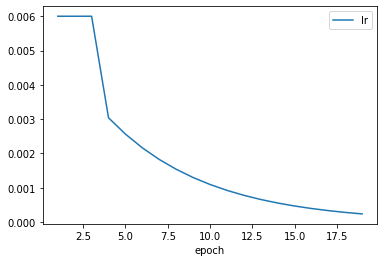

In [33]:
lr_df = pd.DataFrame(zip(list(range(1,20))), columns=['epoch'])
lr_df['lr'] = lr_df['epoch'].apply(schedule)
lr_df.set_index('epoch').plot()

In [34]:
lr_df

,epoch,lr
0,1,0.006000
1,2,0.006000
2,3,0.006000
3,4,0.003040
4,5,0.002564
5,6,0.002164
6,7,0.001825
7,8,0.001540
8,9,0.001299
9,10,0.001096
